In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.1


In [10]:
df = pd.read_csv("bpi2017_filledLog.csv")

In [11]:
df['treatment'] = df['treatment'].replace({'treated': 1, 'notTreated': 0})

In [12]:
treatment=df['treatment']
X = df[['FirstWithdrawalAmount', 'NumberOfTerms', 'MonthlyCost', 'CreditScore', 'OfferedAmount']]
y=df['successful']

In [ ]:
# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
# ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
# print(ate_s)
# print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
# print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
# print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

In [13]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t_xgb = BaseTRegressor(learner=XGBRegressor())
ate_t_xgb = learner_t_xgb.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t_xgb)

# Calling the Base Learner class and feeding in LinearRegression
learner_t_lr = BaseTRegressor(learner=LinearRegression())
ate_t_lr= learner_t_lr.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t_lr)

# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x_xgb = BaseXRegressor(XGBRegressor())
ate_x_xgb = learner_x_xgb.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x_xgb)

# Calling the Base Learner class and feeding in LinearRegression
learner_x_lr = BaseXRegressor(learner=LinearRegression())
ate_x_lr = learner_x_lr.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x_lr)

# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r_xgb = BaseRRegressor(learner=XGBRegressor())
ate_r_xgb = learner_r_xgb.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r_xgb)

# Calling the Base Learner class and feeding in LinearRegression
learner_r_lr = BaseRRegressor(learner=LinearRegression())
ate_r_lr = learner_r_lr.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r_lr)

(array([0.20577068]), array([0.20437408]), array([0.20716727]))
ATE estimate: 0.206
ATE lower bound: 0.204
ATE upper bound: 0.207


KeyboardInterrupt: 

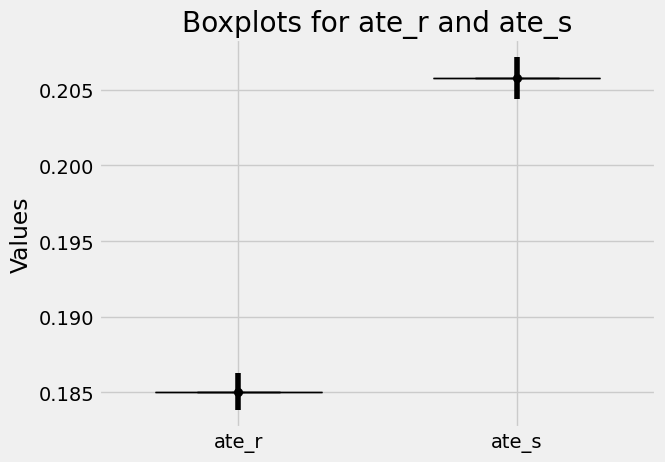

In [33]:
import matplotlib.pyplot as plt

# Extract values for boxplot - ate_r
median_r = ate_t[0][0]
lower_bound_r = ate_t[1][0]
upper_bound_r = ate_t[2][0]

# Extract values for boxplot - ate_s
median_s = ate_s[0][0]
lower_bound_s = ate_s[1][0]
upper_bound_s = ate_s[2][0]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot boxplot for ate_r
bp_r = ax.boxplot([median_r], positions=[1], widths=0.6, patch_artist=True, medianprops={'color': 'black'})
for patch in bp_r['boxes']:
    patch.set_facecolor('lightblue')
ax.scatter([1], median_r, color='black', marker='o')  # Plot median point
ax.errorbar([1], median_r, yerr=[[median_r - lower_bound_r], [upper_bound_r - median_r]], fmt='_', color='black', markersize=8)

# Plot boxplot for ate_s
bp_s = ax.boxplot([median_s], positions=[2], widths=0.6, patch_artist=True, medianprops={'color': 'black'})
for patch in bp_s['boxes']:
    patch.set_facecolor('lightgreen')
ax.scatter([2], median_s, color='black', marker='o')  # Plot median point
ax.errorbar([2], median_s, yerr=[[median_s - lower_bound_s], [upper_bound_s - median_s]], fmt='_', color='black', markersize=8)

# Set labels and title
ax.set_xticks([1, 2])
ax.set_xticklabels(['ate_r', 'ate_s'])
ax.set_ylabel('Values')
ax.set_title('Boxplots for ate_r and ate_s')

# Show the plot
plt.show()


### 7. Calculate Individual Treatment Effect (ITE/CATE)

In [8]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)
print("Cate S: ", cate_s)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)
print("Cate T: ", cate_t)

# X Learner with propensity score input
# learner_x = BaseXRegressor(learner=XGBRegressor())
# cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)
print("Cate X: ", cate_x_no_p)

# R Learner with propensity score input 
# learner_r = BaseRRegressor(learner=XGBRegressor())
# cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)
print("Cate R: ", cate_r_no_p)

Cate S:  [[0.20577068]
 [0.20577068]
 [0.20577068]
 ...
 [0.20577068]
 [0.20577068]
 [0.20577068]]
Cate T:  [[ 0.4055897 ]
 [ 0.4055897 ]
 [ 0.4055897 ]
 ...
 [-0.11846584]
 [-0.11846584]
 [-0.11846584]]
Cate X:  [[ 0.40245716]
 [ 0.40245716]
 [ 0.40245716]
 ...
 [-0.07194634]
 [-0.07194634]
 [-0.07194634]]
Cate R:  [[ 0.36432242]
 [ 0.36432242]
 [ 0.36432242]
 ...
 [-0.13128811]
 [-0.13128811]
 [-0.13128811]]


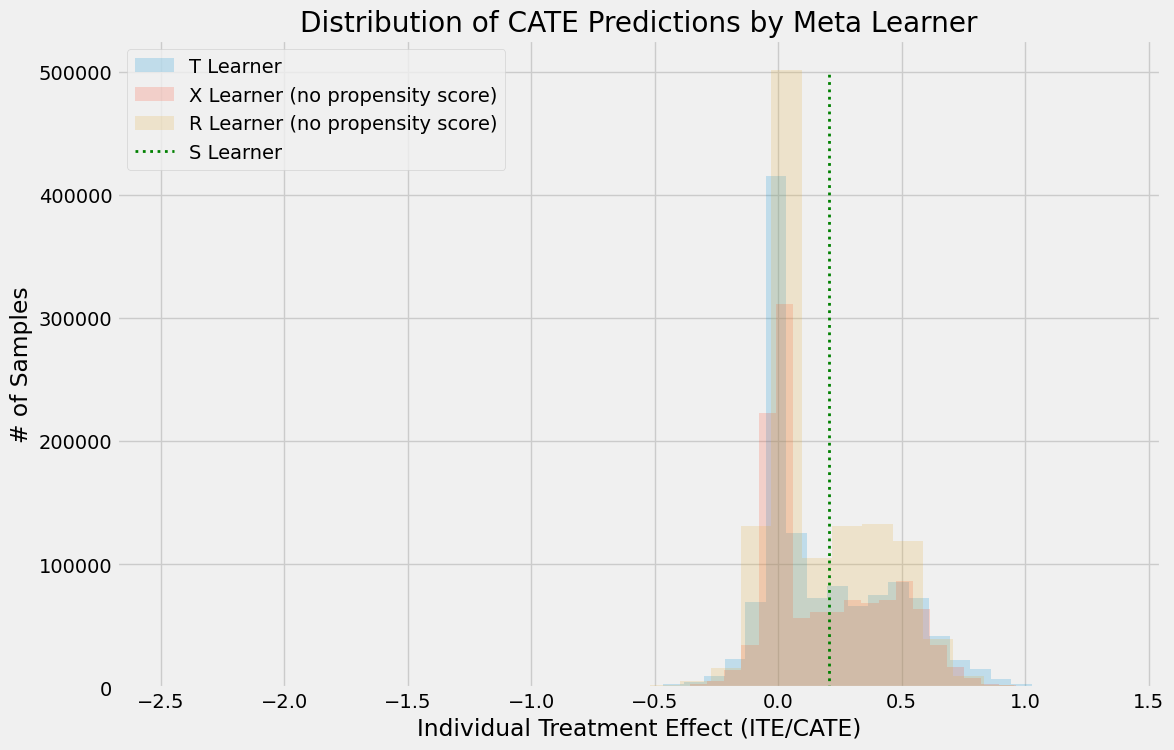

In [28]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], ymin=0, ymax=500000, label='S Learner', linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

### Other Methods

In [16]:
lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.21 (0.20, 0.21)
Average Treatment Effect (XGBoost): 0.19 (0.18, 0.19)
Average Treatment Effect (Neural Network (MLP)): 0.06 (0.06, 0.06)


NameError: name 'e' is not defined